# **Анализ эмбеддингов: практика**

Привет, друзья! В этом домашнем задании вы познакомитесь с базовыми подходами для анализа эмбеддингов и зондирования модели. Мы будем работать с моделью BERT и проанализируем, как в ней располагаются различные части речи, а также посмотрим, достаточно ли извлеченных активаций, чтобы решить задачу классификации семантических сущностей. В качестве дополнительной задачи посмотрим, группируются ли слова, отвечающие за эмоции в модели BERT отдельно.

**Для этого, вы:**

- Извлечёте эмбеддинги из предобученной модели BERT.
- Проведете сжатие размерности, чтобы оценить визуальное представление различных частей речи и кластера эмоций;
- Обучите линейный классификатор, чтобы проверить, достаточно ли различно модель кодирует разные семантические сущности.

Приятной практики!

### **Блок 1. Подготовка данных и модели.**

**Шаг 1.**
Как всегда, загрузим библиотеки.

In [1]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import pandas as pd

Также подготовим набор данных. Он собран заранее и выложен на гитхаб.

In [2]:
words_data = pd.read_csv('https://github.com/SadSabrina/explainable_AI_course/raw/refs/heads/main/HW_module14_LLM/words_data.csv', index_col=[0])
words_data.head()

,word,label
0,softly,3
1,banana,0
2,sadness,4
3,hot,2
4,firmly,3


**Шаг 2.**

Загрузим предобученную модель BERT — *Bidirectional Encoder Representations* — одна из известных моделей-пионеров архитектуры трансформер. Именно bert-base-uncased — это предварительно обученная модель BERT от Google. Обучение проводилось на корпусе английских данных с использованием генерации пропущенного токена (англ. masked language modeling). Модель uncased не различает заглавные и строчные буквы английского текста.

![bert_image](https://cdn-images-1.medium.com/v2/resize:fit:1500/1*g1KBCVCITjrd9IJ7AyFqdw.png)

In [3]:
# Загружаем модель и токенизатор BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# Переводим модель в режим прогнозирования
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

**Задание 1. Проанализипуйте архитектуру модели BERT. Какая размерность эмбеддингов получамых на выходе?**

**Задание 2. Проанализипуйте архитектуру модели BERT. Какая размерность весов внимания?**



**Шаг 3.** Напишем функцию для извлечения эмбеддингов с последнего скрытого слоя.

In [5]:
def extract_embeddings(words, model, tokenizer):
    """
    Извлекает эмбеддинги для списка слов с использованием модели BERT.
    """
    inputs = tokenizer(words, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
    # Возвращаем усреднённые эмбеддинги
    return embeddings.median(dim=1).values

Разберёмся в коде подробно. Сначала происходит кодирование входных слов в виде токенов. Для модели BERT каждое слово может быть кодировано не одним токеном.

In [6]:
tokenizer('cat') # Например, кошка кодируется тремя токенами, где токены 101, 102 — токена начала и конца текстовой последовательности

{'input_ids': [101, 4937, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

**Задание 3. Найдите слово, закодированное самым большим количеством токенов.**

In [7]:
# Ваш код здесь

Далее, формально мы получаем прогноз модели. Однако `BertModel`, которую мы используем в уроке, не имеет слоя для финальной задачи, так что на выходе у нас то, что нужно для анализа — скрытые состояния для каждого токена в последовательности.

In [9]:
from transformers import BertForQuestionAnswering

# Но если мы будем решать задачу — мы решим задачу. Посмотрим на задаче вопрос-ответ

model_example = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Вопрос и текст
question = "Who are cats?"
text = "Cats are the best animal of the world"

# Шаг 1: Токенизация
encoding = tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt")

# Получаем input_ids и token_type_ids
input_ids = encoding["input_ids"]
token_type_ids = encoding["token_type_ids"]

# Прогноз с использованием модели
with torch.no_grad():
    start_scores, end_scores = model_example(input_ids, token_type_ids=token_type_ids).start_logits, model_example(input_ids, token_type_ids=token_type_ids).end_logits

#  Преобразование индексов в токены
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)

# Извлекаем ответ
answer = ' '.join(all_tokens[start_index:end_index+1])

print("Ответ:", answer)

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ответ: the best animal of the world


Вернемся к задаче.

In [12]:
# Токенизация слов
inputs = tokenizer(list(words_data['word']), return_tensors='pt', padding=True, truncation=True)

# Извлекаем эмбеддинги
features = extract_embeddings(list(words_data['word']), model, tokenizer)

print(f"Размерность эмбеддингов: {features.shape}")

Размерность эмбеддингов: torch.Size([91, 768])


Заметим, что в функции мы добавили усреднение эмбеддингов. Это необходимо, так как изначально размер скрытых состояний равен `torch.Size([91, 6, 768])`.

Что соответствует:
- 91 слову
- 6-ти векторам размерности 768 на каждое слово, где каждый вектор кодирует отдельный токен.

После усреднения мы получили в точности вектор представления каждого слова из задачи. А для лучшей информативности, взяли медиану.

**Задание 4. Как кодируется каждое слово, если мы подаем последовательность слов, которые, вообще говоря, кодируются разным количеством токенов?**

### **Блок 2. Визуализация.**



In [13]:
def visualize_embeddings(features, labels, words, method='pca'):
    """
    Визуализирует эмбеддинги с поддержкой нескольких категорий.
    """
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        title = "Визуализация эмбеддингов с помощью PCA"
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = "Визуализация эмбеддингов с помощью t-SNE"
    else:
        raise ValueError("Метод должен быть 'pca' или 'tsne'")

    reduced_embeddings = reducer.fit_transform(features)
    plt.figure(figsize=(10, 8))

    # Уникальные категории
    unique_labels = sorted(set(labels))
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    categories = {0: "Noun", 1: "Verb", 2: "Adjective", 3: "Adverb", 4 : "Emotions"}

    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            [reduced_embeddings[i, 0] for i in indices],
            [reduced_embeddings[i, 1] for i in indices],
            label=categories.get(label, f"Category {label}")
        )

    for i, word in enumerate(words):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=9)

    plt.title(title)
    plt.legend(loc='best')
    plt.show()

И так, первый подход к анализу — визуализация на основе сжатия размерности. Мы будем использовать методы PCA и t-SNE, чтобы спроектировать эмбеддинги на плоскость. Код уже написан выше.

<ipython-input-13-da4c95579a3e>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


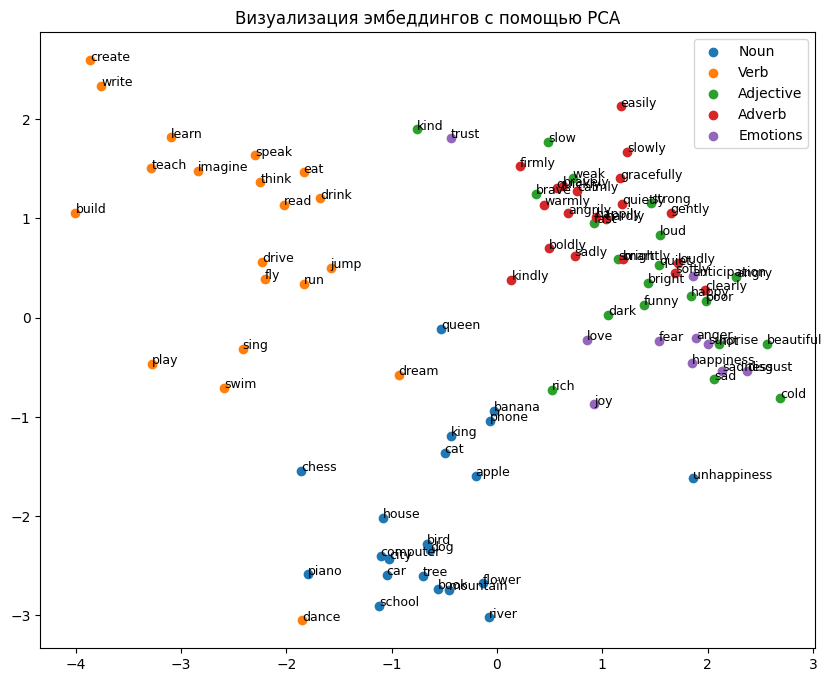

In [14]:
visualize_embeddings(features, words_data['label'], words_data['word'], method='pca')

**Задание 5. Проанализируйте полученные кластеры. Какие категории (две) отделились от остальных сильнее всего?**

**Задание 6. Проанализируйте кластеры. Совпала ли ситуация с сжатием в PCA?**


In [ ]:
visualize_embeddings(features, words_data['label'], words_data['word'], method='tsne')

Как видите, разные методы и стратегии сжатия будут давать разную картинку. Поэтому отсутствие разделимости не значит отсутствия разделения в модели, хотя и указывает на неё.

### **Блок 3. Зондирование.**

И так, на этом этапе мы увидели, что семантические сущности группируются в отдельные кластеры при проекции на двумерное пространство. Достаточно ли этого, чтобы построить линейный классификатор на основе выученныъ эмбеддингов?

Исследуем этот вопрос при помощи зондирования.  

In [16]:
features.shape

torch.Size([91, 768])

**Обратите внимание:** количество признаков сейчас больше количества наблюдений. Стало быть, необходимо сжать данные, чтобы извбежать переобучения. Это мы и сделаем в первом шаге.

Сожмем данные так, чтобы в компонентах сохранилось хотя-бы 70% объясняемой дисперсии данных.

In [17]:
pca = PCA(n_components=22)
features_pca = pca.fit_transform(features)

sum(pca.explained_variance_ratio_)

0.7061456855548186

Попробуем решить две задачи.

1. Классификация частей речи — существительных, прилагательных, глаголов и наречий;
2. Классификация эмоций — класс эмоции против остальных;

Так как эмоции выражены существительными, в задаче 1 мы просто объединим их с существительными.

Метки классов:
* 0 - существительное;
* 1 - глагол;
* 2 - прилагательное;
* 3 - наречие;
* 4 — эмоции;
    

In [18]:
features_pca_data = pd.DataFrame(features_pca, columns=[f'component_{i}' for i in range(1, 23)])

first_task_labels = list(map(lambda x: 0 if x == 4 else x, words_data['label']))
second_task_labels = list(map(lambda x: 0 if x != 4 else 1,  words_data['label']))

Обучим модели для задач и оценим качество.

In [19]:
from sklearn.model_selection import train_test_split

features_pca_data_train, features_pca_data_test, first_task_labels_train, first_task_labels_test = train_test_split(features_pca_data,
                                                                                                                    first_task_labels,
                                                                                                                    random_state=42,
                                                                                                                    test_size=0.3)

second_task_labels_train, second_task_labels_test = train_test_split(second_task_labels, random_state=42, test_size=0.3)


In [20]:
# Инициализация моделей
first_task_model = LogisticRegression()
second_task_model = LogisticRegression()

Обучение и оценка.

First probing task Accuracy: 0.96

First probing task classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7

    accuracy                           0.96        28
   macro avg       0.97      0.94      0.95        28
weighted avg       0.97      0.96      0.96        28



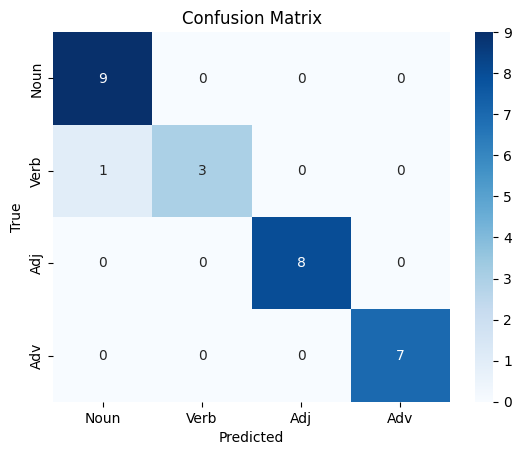

In [21]:
# Первая задача

first_task_model.fit(features_pca_data_train, first_task_labels_train)
first_task_predictions = first_task_model.predict(features_pca_data_test)
accuracy = accuracy_score(first_task_labels_test, first_task_predictions)

print(f"First probing task Accuracy: {accuracy:.2f}")
print("\nFirst probing task classification Report:\n", classification_report(first_task_labels_test, first_task_predictions))

conf_matrix = confusion_matrix(first_task_labels_test, first_task_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Noun', 'Verb', 'Adj', 'Adv'], yticklabels=['Noun', 'Verb', 'Adj', 'Adv'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Задание 7. Дополните код обучения зонда для второй задачи. Оцените точность модели — чему равно количество некорректных ответов на тестовых даных?**


In [ ]:
# Вторая задача

second_task_model.fit(features_pca_data_train, second_task_labels_train)

second_task_predictions = # Ваш код здесь
accuracy = # Ваш код здесь

print(f"Second probing task Accuracy: {accuracy:.2f}")
print("\nSecond probing task classification Report:\n", classification_report(second_task_labels_test, second_task_predictions))

conf_matrix = confusion_matrix(second_task_labels_test, second_task_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not emotion', 'Emotion'], yticklabels=['Not emotion', 'Emotion'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Завершение**

Таким образом, зондирование показало, что на основе эмбеддингов данные в поставленных задачах можно разделить линейно. Такие результаты не являются редкими и с ними связана гипотеза линейности — одна из центральных гипотез MI.

**Механистическая интерпретируемость (MI)** — подобласть XAI, которая стремится понять внутренние механизмы работы нейронных сетей. Гипотеза линейности, сформулированная исследователями области, предполагает, что признаки 𝑓𝑖 в сетях являются линейными комбинациями активаций нейронов. Существование линейных зондов показывает, что концепции, представленные в активациях сети, можно извлечь с помощью линейных моделей.

Но существуют задачи, в которых сеть формирует нелинейные представления. Одним из примеров является решение задач модульной арифметики (например, работы с датами), где признаки нельзя разделить линейной гиперплоскостью. Это демонстрирует, что линейное представление — не универсальное правило. Но то, что мы видим эмпирически — удивительно!

И красота сетей на этом не заканчивается!
Надеюсь, последнее задание курса дало вам ощутить ещё больший интерес к моделям.
Спасибо за выполнение!

